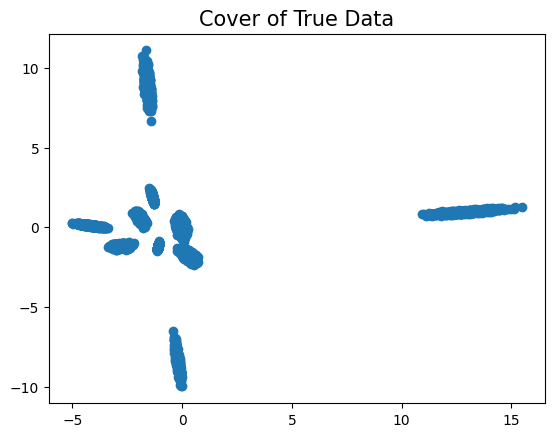

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import numpy as np

## Visualization

from sklearn.decomposition import PCA
pca = PCA(n_components=2)

## Set seed

np.random.seed(1233)
torch.manual_seed(1233)

## Data generation: Reference from https://github.com/andrewgordonwilson/bayesgan

x_dim = 100
N = 10000
true_z_dim = 2

### generate synthetic data
Xs = []
for _ in range(10):
    cluster_mean = np.random.randn(true_z_dim) * 5# to make them more spread
    A = np.random.randn(x_dim,true_z_dim) * 5
    X = np.dot(np.random.randn(int(N / 10), true_z_dim)*0.5 + cluster_mean, A.T)
    Xs.append(X)
X_raw = np.concatenate(Xs)
X = (X_raw - X_raw.mean(0)) / (X_raw.std(0))

X=torch.from_numpy(X).float()

### visualization of the true data

import matplotlib
X_trans_real = pca.fit_transform(X)
x = X_trans_real[:, 0]
y = X_trans_real[:, 1]
matplotlib.pyplot.scatter(x, y)
matplotlib.pyplot.title("Cover of True Data",fontsize=15)
matplotlib.pyplot.show()


### NN structures

class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc1.weight)
        self.relu = nn.ReLU()

        self.fc2 = nn.Linear(hidden_dim, output_dim)
        nn.init.xavier_normal_(self.fc2.weight)
        #self.sig=nn.Sigmoid()

    def forward(self, x):
        # Linear function
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        #out= self.sig(out)
        return out


### Setting for GANs

nz=10
batch_size = 64

J_g=10 # Number of generators
J_d=1  # Number of discriminators

G=[None]*J_g
D=[None]*J_d

noise_G=[None]*J_g
noise_D=[None]*J_d

G_optimizer=[None]*J_g
D_optimizer=[None]*J_d


learning_rate=1
lr_g=0.5

for i in range(J_g):
    G[i]=FeedforwardNeuralNetModel(nz,1000, x_dim).cuda()
    G_optimizer[i]=torch.optim.SGD(G[i].parameters(),lr=lr_g)
for i in range(J_d):
    D[i]=FeedforwardNeuralNetModel(x_dim,1000, 1).cuda()
    D_optimizer[i]=torch.optim.SGD(D[i].parameters(),lr=learning_rate)

### Setting for MSGLD: Reference from https://www.tandfonline.com/doi/full/10.1080/00949655.2021.1958812

a=1
beta_1=0.9
tau=0.01

n=0
for p in G[0].parameters():
    n=n+1

M=[]
for j in range(J_g):
  M.append([None]*n)

for j in range(J_g):
    n=0
    for par in G[0].parameters():
        M[j][n]=torch.zeros(par.size()).cuda()
        n=n+1

### Check discriminator outputs

Dis=torch.zeros(251)
Gen=torch.zeros(251)
mean_sample=128



loss_criteria=nn.BCEWithLogitsLoss()

real=torch.ones(batch_size).cuda()
fake=torch.zeros(batch_size).cuda()

js=0
sig=nn.Sigmoid()

fake_data = []

for iter in range(2501):

    # Train Generator
    for i in range(J_g):
        noise_G[i]=2*torch.rand(batch_size,nz).cuda()-1


    for j in range(J_g):

        G_loss=0

        Gen_Dis=D[0](G[j](noise_G[j])).view(batch_size).requires_grad_()
        #G_loss=G_loss+loss_criteria(Gen_Dis,real)
        G_loss=G_loss-loss_criteria(Gen_Dis,fake) #mini-max case


        l2=0.0
        for p in G[j].parameters():
            l2=l2+(p**2).sum()/2

        G_loss=G_loss+l2/N


        G_optimizer[j].zero_grad()

        G_loss.backward()
        G_optimizer[j].step()


        n=0
        for par in G[j].parameters():
            par.data.sub_(a*M[j][n]*lr_g/N)
            n=n+1

        with torch.no_grad():
            for param in G[j].parameters():
                param.add_(torch.randn(param.size()).cuda() * np.sqrt(2*tau*lr_g/N))

        n=0
        for par in G[j].parameters():
            M[j][n]*=beta_1
            M[j][n]+=(1-beta_1)*par.grad.data*N
            n=n+1

    for i in range(J_d):
        noise_D[i]=2*torch.rand(batch_size,nz).cuda()-1

    for j in range(J_d):

        D_loss=0

        lr_d=learning_rate*(iter+1000)**(-3/4)
        for param_group in D_optimizer[j].param_groups:
          param_group['lr'] = lr_d


        perm = torch.randperm(N)
        idx=perm[:batch_size]
        X_batch=X[idx,].requires_grad_().cuda()

	# ################## For Lipshitz penalty #########################
  #       alpha=[]

  #       for i in range(batch_size*J_g):
  #         if (len(alpha)==0):
  #           alpha=torch.rand(1).cuda().repeat(100)
  #         else:
  #           al=torch.rand(1).cuda()
  #           alpha=torch.cat((alpha,al.repeat(100)),0)
  #       alpha=alpha.reshape((64*J_g,100))
  #       gen_image=[]
  #       for i in range(J_g):
  #         if (len(gen_image)==0):
  #           gen_image=G[i](noise_D[0])
  #         else: gen_image=torch.cat((gen_image,G[i](noise_D[0])),0)


  #       real_image=X[perm[:batch_size*J_g]].cuda()

  #       interpolates=Variable(gen_image*alpha+(1-alpha)*real_image,requires_grad=True)

  #       grad_output=D[j](interpolates)
  #       gradients=torch_grad(outputs=grad_output ,inputs=interpolates   ,  grad_outputs=torch.ones(grad_output.size()).cuda()  ,create_graph=True,  retain_graph = True  )[0]
  #       grad = gradients.view(batch_size*J_g, -1)

  #       sq=(grad**2)
  #       sl=torch.max(torch.sum(sq,1))
	# ########################################################################
        for k in range(J_g):
          D_loss+= loss_criteria(D[j](X_batch).view(batch_size).requires_grad_(),real)+loss_criteria(D[j](G[k](noise_D[0])).view(-1),fake)

        D_loss=D_loss/J_g
	## If LGAN: D_loss=D_loss/J_g +5*sl

        D_optimizer[j].zero_grad()

        D_loss.backward()
        D_optimizer[j].step()


    if (iter+1)%10==1:
      with torch.no_grad():
        perm = torch.randperm(N)
        idx=perm[:mean_sample]
        X_batch=X[idx,].requires_grad_().cuda()
        mean=0
        for i in range(J_g):
          mean+=torch.mean(sig(D[0](G[i](2*torch.rand(mean_sample,nz).cuda()-1)).view(-1)))
        Gen[js]=mean/J_g
        Dis[js]=torch.mean(sig(D[0](X_batch).view(mean_sample)))
        js=js+1

Dis=Dis.detach().numpy()
Gen=Gen.detach().numpy()


### Collect fake samples

fake_data = []
for num_samples in range(20):
    for g in range(J_g):
        sample_z = 2*torch.rand(50,nz).cuda()-1
        sampled_data = G[g](sample_z).detach().cpu().numpy()
        fake_data.append(sampled_data)

X_sample = np.concatenate(fake_data)

X_trans_fake = pca.transform(X_sample)

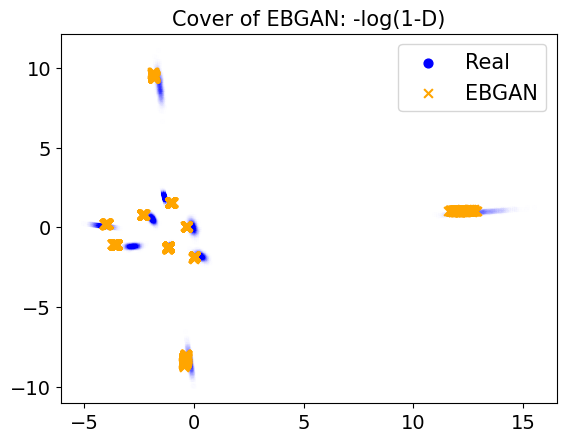

In [4]:
matplotlib.pyplot.title("Cover of EBGAN: -log(1-D)",fontsize=15)
x = X_trans_real[:, 0]
y = X_trans_real[:, 1]
matplotlib.pyplot.scatter(x, y,color='blue',label="Real",alpha=0.002,s=10)
# matplotlib.pyplot.legend(fontsize="40", markerscale=40)
x = X_trans_fake[:, 0]
y = X_trans_fake[:, 1]
matplotlib.pyplot.scatter(x, y,color='orange',label="EBGAN",marker="x",s=40)
lgnd=matplotlib.pyplot.legend(fontsize="15")
matplotlib.pyplot.xticks(fontsize=14)
matplotlib.pyplot.yticks(fontsize=14)
lgnd.legend_handles[0]._sizes = [40]
lgnd.legend_handles[0].set_alpha(1)
# lgnd.legend_handles[1]._legmarker.set_markersize(6)
matplotlib.pyplot.show()


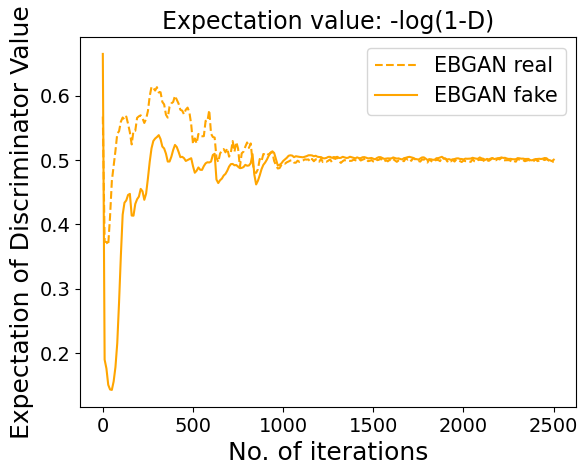

In [5]:


matplotlib.pyplot.title("Expectation value: -log(1-D)",fontsize=17)
matplotlib.pyplot.plot(np.multiply(range(251),10)+1,Dis,label="EBGAN real",color='orange',linestyle='--')
matplotlib.pyplot.plot(np.multiply(range(251),10)+1,Gen,label="EBGAN fake",color='orange',linestyle='-')
matplotlib.pyplot.xlabel('No. of iterations',fontsize=18)
matplotlib.pyplot.ylabel('Expectation of Discriminator Value',fontsize=18)
matplotlib.pyplot.legend()
matplotlib.pyplot.legend(fontsize="15")
matplotlib.pyplot.xticks(fontsize=14)
matplotlib.pyplot.yticks(fontsize=14)
matplotlib.pyplot.show()
